In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    dataset_name="evaluate-detections-tutorial",
)
dataset.persistent = True

Found annotations at '/home/dan/fiftyone/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'evaluate-detections-tutorial'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [2]:
print(dataset)

Name:        evaluate-detections-tutorial
Media type:  image
Num samples: 5000
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [3]:
# Print a ground truth detection
sample = dataset.first()
print(sample.ground_truth.detections[0])

<Detection: {
    'id': '663ba4b4cff68a59420a974f',
    'attributes': {},
    'tags': [],
    'label': 'potted plant',
    'bounding_box': [
        0.37028125,
        0.3345305164319249,
        0.038593749999999996,
        0.16314553990610328,
    ],
    'mask': None,
    'confidence': None,
    'index': None,
    'supercategory': 'furniture',
    'iscrowd': 0,
}>


/home/dan/anaconda3/envs/dev/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Using cache found in /home/dan/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-5-8 Python-3.9.18 torch-2.2.2+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


 100% |███████████████| 5000/5000 [4.2m elapsed, 0s remaining, 17.6 samples/s]      



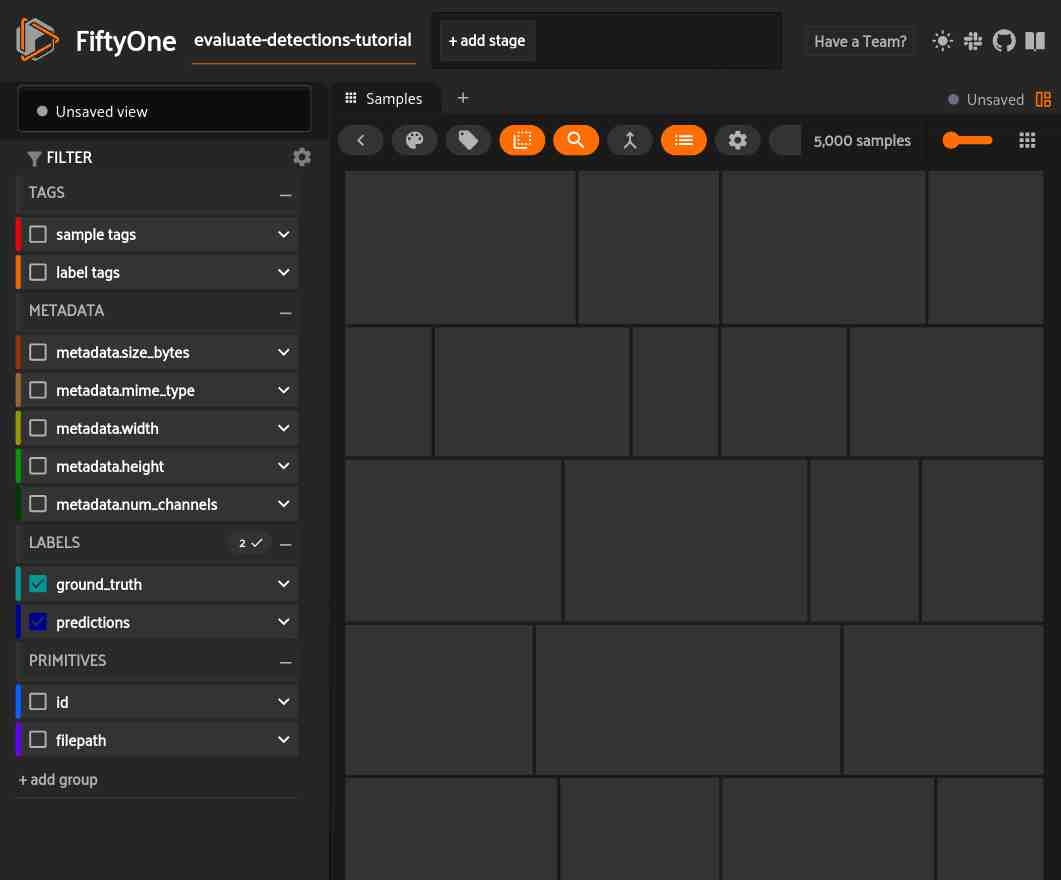

In [4]:
model = foz.load_zoo_model("yolov8s-coco-torch")

dataset.apply_model(model, label_field="predictions")

session = fo.launch_app(dataset)

In [ ]:
# Click the down caret on the `faster_rcnn` field of Fields Sidebar
# and apply a confidence threshold
session.show()

In [13]:
from fiftyone import ViewField as F

# Only contains detections with confidence >= 0.75
high_conf_view = dataset.filter_labels("predictions", F("confidence") > 0.75, only_matches=False)

In [ ]:
# Print some information about the view
print(high_conf_view)

In [ ]:
# Print a prediction from the view to verify that its confidence is > 0.75
sample = high_conf_view.first()
print(sample.faster_rcnn.detections[0])

In [ ]:
OBJECT PATCHES

In [6]:
# Evaluate the predictions in the `predictions` field of our dataset
# with respect to the objects in the `ground_truth` field
results = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)

Evaluating detections...
 100% |███████████████| 5000/5000 [39.9s elapsed, 0s remaining, 126.4 samples/s]      
Performing IoU sweep...
 100% |███████████████| 5000/5000 [29.9s elapsed, 0s remaining, 173.8 samples/s]      


In [9]:
# Print a classification report
results.print_report()

# Print out the mAP score
print(f"Yolov8s mAP score: {results.mAP()}")

                precision    recall  f1-score   support

      airplane       0.79      0.80      0.79       143
         apple       0.43      0.30      0.35       240
      backpack       0.50      0.28      0.36       371
        banana       0.69      0.45      0.55       423
  baseball bat       0.69      0.49      0.57       146
baseball glove       0.63      0.52      0.57       148
          bear       0.78      0.87      0.83        71
           bed       0.67      0.49      0.57       163
         bench       0.58      0.30      0.39       413
       bicycle       0.69      0.47      0.56       316
          bird       0.81      0.51      0.63       490
          boat       0.61      0.42      0.50       432
          book       0.62      0.25      0.36      1234
        bottle       0.68      0.52      0.59      1072
          bowl       0.60      0.53      0.56       635
      broccoli       0.52      0.40      0.45       322
           bus       0.84      0.69      0.76  

In [10]:
# Get the 10 most common classes in the dataset
counts = dataset.count_values("ground_truth.detections.label")
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 classes
results.print_report(classes=classes_top10)

               precision    recall  f1-score   support

       person       0.86      0.73      0.79     11730
          car       0.71      0.60      0.65      1970
        chair       0.64      0.45      0.53      1834
         book       0.62      0.25      0.36      1234
       bottle       0.68      0.52      0.59      1072
          cup       0.62      0.56      0.59       918
 dining table       0.60      0.34      0.43       697
traffic light       0.65      0.50      0.56       639
         bowl       0.60      0.53      0.56       635
      handbag       0.55      0.22      0.31       540

    micro avg       0.77      0.61      0.68     21269
    macro avg       0.65      0.47      0.54     21269
 weighted avg       0.76      0.61      0.67     21269



In [14]:
# Evaluate the predictions in the `predictions` field of our `high_conf_view`
# with respect to the objects in the `ground_truth` field
results = high_conf_view.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval_high_conf",
    compute_mAP=True,
)

Evaluating detections...
 100% |███████████████| 5000/5000 [32.1s elapsed, 0s remaining, 170.5 samples/s]      
Performing IoU sweep...
 100% |███████████████| 5000/5000 [23.0s elapsed, 0s remaining, 210.4 samples/s]      


In [ ]:
!pip install 'ipywidgets>=8,<9'

In [15]:
plot = results.plot_pr_curves(classes=["person", "car"])
plot.show()

FigureWidget({
    'data': [{'customdata': array([    0.95676,     0.93567,     0.92634,      0.9189,     0.91175,
                                       0.90284,     0.81493,     0.80953,     0.80494,     0.80048,
                                       0.79551,     0.79013,     0.78455,      0.7793,     0.77363,
                                       0.76662,      0.7607,     0.75417,     0.74756,     0.66776,
                                       0.66278,     0.65739,     0.65174,     0.64595,     0.63956,
                                       0.63379,     0.55401,     0.54896,     0.54405,     0.46364,
                                       0.45852,     0.37914,     0.22584,           0,           0,
                                             0,           0,           0,           0,           0,
                                             0,           0,           0,           0,           0,
                                             0,           0,           0,           0

In [ ]:
EVAL VIEWS

In [ ]:
eval_patches = dataset.to_evaluation_patches("eval")
print(eval_patches)

In [ ]:
# Show samples with most true positives
session.view = high_conf_view.sort_by("eval_tp", reverse=True)

In [ ]:
# Show samples with most false positives
session.view = high_conf_view.sort_by("eval_fp", reverse=True)

In [ ]:
# Compute metadata so we can reference image height/width in our view
dataset.compute_metadata()

In [ ]:
#
# Create an expression that will match objects whose bounding boxes have
# area less than 32^2 pixels
#
# Bounding box format is [top-left-x, top-left-y, width, height]
# with relative coordinates in [0, 1], so we multiply by image
# dimensions to get pixel area
#
bbox_area = (
    F("$metadata.width") * F("bounding_box")[2] *
    F("$metadata.height") * F("bounding_box")[3]
)
small_boxes = bbox_area < 32 ** 2

# Create a view that contains only small (and high confidence) predictions
small_boxes_view = high_conf_view.filter_labels("faster_rcnn", small_boxes)

session.view = small_boxes_view

In [ ]:
# Create a view that contains only small GT and predicted boxes
small_boxes_eval_view = (
    high_conf_view
    .filter_labels("ground_truth", small_boxes, only_matches=False)
    .filter_labels("predictions", small_boxes, only_matches=False)
)

# Run evaluation
small_boxes_results = small_boxes_eval_view.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
)

In [ ]:
# Get the 10 most common small object classes
small_counts = small_boxes_eval_view.count_values("ground_truth.detections.label")
classes_top10_small = sorted(small_counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 small object classes
small_boxes_results.print_report(classes=classes_top10_small)